In [2]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
import cv2
import numpy as np

from PIL import Image
import numpy as np
from skimage.restoration import denoise_wavelet
from skimage.filters import sobel
from skimage.exposure import equalize_adapthist
import skimage

from sklearn.model_selection import train_test_split

C:\Users\pehfa\AppData\Local\Temp\ipykernel_17696\941162035.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load Data

In [6]:
# Construct paths to 'real' and 'fake' directories
real_path = '../data/raw/face_real'
fake_path = '../data/raw/face_fake/1m_faces_00'

images_df = {
    "image_path":[],
    "label":[]
}

# Process real images
for subfolder in ['00000', '01000']:
    full_path = os.path.join(real_path, subfolder)
    for file_extension in ["*.jpg", "*.png"]:
        for img in glob.glob(os.path.join(full_path, file_extension)):
            images_df["image_path"].append(img)
            images_df["label"].append('real')
            
# Process fake images, limiting to 2000
count = 0
for file_extension in ["*.jpg", "*.png"]:
    for img in glob.glob(os.path.join(fake_path, file_extension)):
        if count < 2000:  # Limit to 2000 images
            images_df["image_path"].append(img)
            images_df["label"].append('fake')
            count += 1
        else:
            break

# Convert to DataFrame
images_df = pd.DataFrame(images_df)

In [7]:
# View the shape of the DataFrame (rows, columns)
shape = images_df.shape
print(f"Shape of the DataFrame: {shape}")

# Display the first few rows to inspect
print("First few rows of the DataFrame:")
print(images_df.head())

# Get a summary of the DataFrame
print("Summary of the DataFrame:")
print(images_df.info())

Shape of the DataFrame: (4000, 2)
First few rows of the DataFrame:
                              image_path label
0  ../data/raw/face_real\00000\00000.png  real
1  ../data/raw/face_real\00000\00001.png  real
2  ../data/raw/face_real\00000\00002.png  real
3  ../data/raw/face_real\00000\00003.png  real
4  ../data/raw/face_real\00000\00004.png  real
Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  4000 non-null   object
 1   label       4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


# Preprocessing

In [8]:
def resize_image(image: Image.Image, size: tuple[int, int] = (128, 128)) -> Image.Image:
    return image.resize(size)

def normalize_pixels(image_array: np.ndarray) -> np.ndarray:
    return image_array / 255.0

def convert_to_grayscale(image: Image.Image) -> Image.Image:
    return image.convert('L')

def denoise_image(image: np.ndarray) -> np.ndarray:
    # Assuming multichannel is based on the input image shape
    multichannel = image.shape[-1] == 3
    return denoise_wavelet(image, multichannel=multichannel, mode='soft')

def apply_edge_detection(image: np.ndarray) -> np.ndarray:
    return sobel(image)

def equalize_histogram(image: np.ndarray) -> np.ndarray:
    return equalize_adapthist(image, clip_limit=0.03)

def center_crop(image: Image.Image, crop_size: int) -> Image.Image:
    width, height = image.size
    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2
    return image.crop((left, top, right, bottom))

def standardize_image(image: np.ndarray, mean: float, std: float) -> np.ndarray:
    return (image - mean) / std

def to_numpy_array(image: Image.Image) -> np.ndarray:
    return np.array(image)

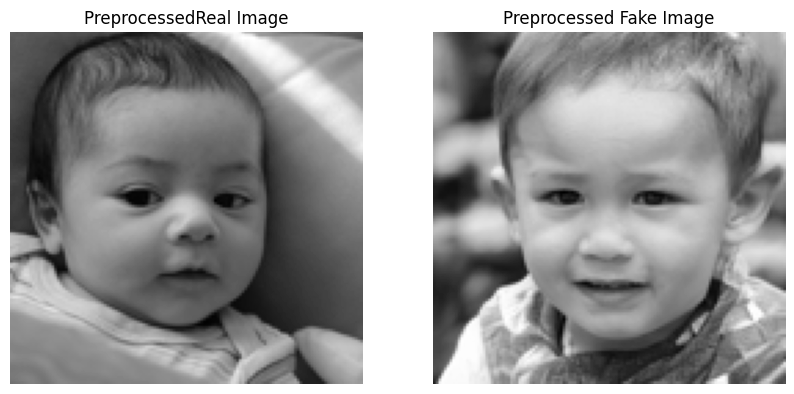

In [9]:
def preprocess_pipeline(image_path: str, size: tuple[int, int] = (128, 128), normalize: bool = True, 
                        to_grayscale: bool = False, denoise: bool = False, edge_detection: bool = False, 
                        equalize: bool = False, center_crop_size: int = None, 
                        standardize: bool = False, mean_std: tuple[float, float] = None) -> np.ndarray:
    try:
        with Image.open(image_path) as img:
            img = resize_image(img, size=size)
            
            if to_grayscale:
                img = convert_to_grayscale(img)
            
            img_array = to_numpy_array(img)
            
            if denoise:
                img_array = denoise_image(img_array)
            
            if edge_detection:
                img_array = apply_edge_detection(img_array)
            
            if equalize:
                img_array = equalize_histogram(img_array)
            
            if center_crop_size:
                img = Image.fromarray((img_array * 255).astype(np.uint8))
                img = center_crop(img, center_crop_size)
                img_array = to_numpy_array(img)
            
            if normalize:
                img_array = normalize_pixels(img_array)
            
            if standardize and mean_std:
                mean, std = mean_std
                img_array = standardize_image(img_array, mean, std)
            
            return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [11]:
preprocessed_images = []

for index, row in images_df.iterrows():
    preprocessed_image = preprocess_pipeline(
        image_path=row['image_path'],
        size=(128, 128),
        normalize=True,
        to_grayscale=False,
        denoise=False,  # Adjust according to your requirements
        edge_detection=False,
        equalize=False,
        center_crop_size=None,
        standardize=False
    )
       
    label = 0 if row['label'] == 'real' else 1  # Assign 0 to real, 1 to fake
    preprocessed_images.append((preprocessed_image, label))

    print(f"Processed {os.path.basename(row['image_path'])}")

Processed 00000.png
Processed 00001.png
Processed 00002.png
Processed 00003.png
Processed 00004.png
Processed 00005.png
Processed 00006.png
Processed 00007.png
Processed 00008.png
Processed 00009.png
Processed 00010.png
Processed 00011.png
Processed 00012.png
Processed 00013.png
Processed 00014.png
Processed 00015.png
Processed 00016.png
Processed 00017.png
Processed 00018.png
Processed 00019.png
Processed 00020.png
Processed 00021.png
Processed 00022.png
Processed 00023.png
Processed 00024.png
Processed 00025.png
Processed 00026.png
Processed 00027.png
Processed 00028.png
Processed 00029.png
Processed 00030.png
Processed 00031.png
Processed 00032.png
Processed 00033.png
Processed 00034.png
Processed 00035.png
Processed 00036.png
Processed 00037.png
Processed 00038.png
Processed 00039.png
Processed 00040.png
Processed 00041.png
Processed 00042.png
Processed 00043.png
Processed 00044.png
Processed 00045.png
Processed 00046.png
Processed 00047.png
Processed 00048.png
Processed 00049.png


In [12]:
preprocessed_images_df = pd.DataFrame(preprocessed_images, columns=['image', 'label'])

# Split the Data

In [13]:
from sklearn.model_selection import train_test_split
import numpy as np

# Splitting the DataFrame into features and target arrays
X = np.stack(preprocessed_images_df['image'].values)  # Convert column of arrays into single numpy array
y = preprocessed_images_df['label'].values

# First split to separate out the test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Second split to separate out the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

'''
Training Set: 60% of the original dataset.
Validation Set: 20% of the original dataset.
Testing Set: 20% of the original dataset.
'''

Training set size: 2400
Validation set size: 800
Testing set size: 800


'\nTraining Set: 60% of the original dataset.\nValidation Set: 20% of the original dataset.\nTesting Set: 20% of the original dataset.\n'

Since the images are already loaded and preprocessed, you don't need a separate function to load them for your model training. You can directly use X_train, X_val, X_test, y_train, y_val, and y_test for training and evaluating your model.